In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性
feature_importance = {}
for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 综合评分 = 0.4*相关系数 + 0.3*互信息 + 0.3*最大滞后相关
        composite_score = 0.4 * abs(spearman_corr) + 0.3 * mi_score + 0.3 * abs(max_lag_corr)
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag
        }
# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:15]
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag']
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 15影响因子:")
print(results_df.to_string(index=False))



各目标变量的Top 15影响因子:
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)
 density_mean_y     temperature 0.533         0.561  0.450   0.580         7
 density_mean_y min_temperature 0.476         0.546  0.282   0.577         4
 density_mean_y max_temperature 0.469         0.533  0.267   0.585         3
 density_mean_y          oxygen 0.426        -0.440  0.329  -0.505        15
 density_mean_y              TN 0.412        -0.442  0.316  -0.468         4
 density_mean_y    conductivity 0.411        -0.412  0.401  -0.420         5
 density_mean_y              pH 0.328         0.335  0.306   0.342         1
 density_mean_y             aqi 0.256        -0.351  0.078  -0.309         1
 density_mean_y        aqiLevel 0.247        -0.330  0.095  -0.288         1
 density_mean_y              TP 0.241         0.272  0.216   0.224         1
 density_mean_y    permanganate 0.230         0.235  0.272   0.182         1
 density_mean_y       turbidity 0.227         0.290  0.15

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
def preprocess_data(df, sequence_length, prediction_step=3):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 对weather列进行独热编码
    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取叶绿素a浓度的TOP15特征
    sorted_features = sorted(feature_importance['chla_mean'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:15]
    features = [feature[0] for feature in sorted_features]
    
    # 检查特征是否存在于数据集中
    available_features = [f for f in features if f in df.columns]
    logging.info(f"Number of chlorophyll features: {len(available_features)}")
    logging.info(f"Chlorophyll features: {available_features}")
    
    # 添加目标变量
    available_features.append('chla_mean')
    df_features = df[available_features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=available_features, index=df.index)

    # 分割2024年前后的数据
    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    # 创建训练序列
    train_sequences = []
    for i in range(len(train_data) - sequence_length - prediction_step + 1):
        train_sequences.append(train_data.iloc[i:i+sequence_length].values)
    train_sequences = np.array(train_sequences)

    # 创建测试序列
    test_sequences = []
    for i in range(len(test_data) - sequence_length - prediction_step + 1):
        test_sequences.append(test_data.iloc[i:i+sequence_length].values)
    test_sequences = np.array(test_sequences)

    # 分割输入和目标
    X_train = train_sequences[:, :-prediction_step, :-1]  # 不包含目标变量
    y_train = train_sequences[:, -prediction_step, -1]    # 只预测叶绿素a浓度
    
    X_test = test_sequences[:, :-prediction_step, :-1]
    y_test = test_sequences[:, -prediction_step, -1]

    return X_train, y_train, X_test, y_test, scaler, available_features[:-1]

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss for target 1: {avg_loss:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Chlorophyll', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Chlorophyll', color='red')
    plt.title('Chlorophyll Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Chlorophyll Concentration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 2
        output_size = 1  # 只预测叶绿素a浓度
        criterion = nn.MSELoss()
        epochs = 1000
        prediction_step = 7  # 预测未来7天
        sequence_length = 14  # 使用过去14天数据

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {prediction_step}")
        X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_step)
        input_size = len(features)

        train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_lstm_model(model, train_loader, criterion, optimizer, epochs)

        predictions, targets = evaluate_lstm_model(model, test_loader)

        # 计算RMSE和MAE
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        mae = mean_absolute_error(targets, predictions)

        logging.info("\nPrediction Accuracy Evaluation:")
        logging.info(f"Chlorophyll RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        # 绘制预测结果
        plot_forecast(targets, predictions, title='LSTM Prediction Results')

    except Exception as e:
        logging.error(f"Program error: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()

2024-11-13 09:08:15,508 - INFO - Successfully loaded data file


2024-11-13 09:08:15,509 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-13 09:08:15,517 - INFO - Number of chlorophyll features: 15
2024-11-13 09:08:15,518 - INFO - Chlorophyll features: ['pH', 'permanganate', 'TP', 'max_temperature', 'temperature', 'min_temperature', 'TN', 'weather_阴', 'oxygen', 'weather_小雨', 'b4', 'weather_霾', 'b1', 'b3', 'b2']
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect result

KeyboardInterrupt: 

## 训练2个模型，一个预测密度，一个预测chla

2024-11-13 09:35:29,692 - INFO - Successfully loaded data file
2024-11-13 09:35:29,693 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-13 09:35:29,700 - INFO - Number of features used: 24
2024-11-13 09:35:29,701 - INFO - Available features: ['nrfi', 'b5', 'TN', 'temperature', 'max_temperature', 'weather_霾', 'NH', 'permanganate', 'b1', 'aqi', 'conductivity', 'b3', 'evi', 'b2', 'weather_阴', 'FAI', 'b4', 'TP', 'oxygen', 'min_temperature', 'aqiLevel', 'pH', 'weather_小雨', 'turbidity']


2024-11-13 09:35:29,725 - INFO - Training data shape: (1075, 7, 26)
2024-11-13 09:35:29,726 - INFO - Training labels shape: (1075, 2)
2024-11-13 09:35:29,729 - INFO - Training data range: [0.0000, 1.0000]
2024-11-13 09:35:29,729 - INFO - Training labels range: [0.0000, 1.0000]
2024-11-13 09:35:29,771 - INFO - Sample outputs range: [-0.1383, 0.2561]
2024-11-13 09:35:29,772 - INFO - Sample targets range: [0.0000, 0.4636]
2024-11-13 09:35:30,526 - INFO - Epoch 10/200, Average Loss for target 0: 0.0090
2024-11-13 09:35:31,199 - INFO - Epoch 20/200, Average Loss for target 0: 0.0053
2024-11-13 09:35:31,910 - INFO - Epoch 30/200, Average Loss for target 0: 0.0036
2024-11-13 09:35:32,852 - INFO - Epoch 40/200, Average Loss for target 0: 0.0031
2024-11-13 09:35:34,436 - INFO - Epoch 50/200, Average Loss for target 0: 0.0028
2024-11-13 09:35:35,967 - INFO - Epoch 60/200, Average Loss for target 0: 0.0028
2024-11-13 09:35:37,825 - INFO - Epoch 70/200, Average Loss for target 0: 0.0024
2024-11-13

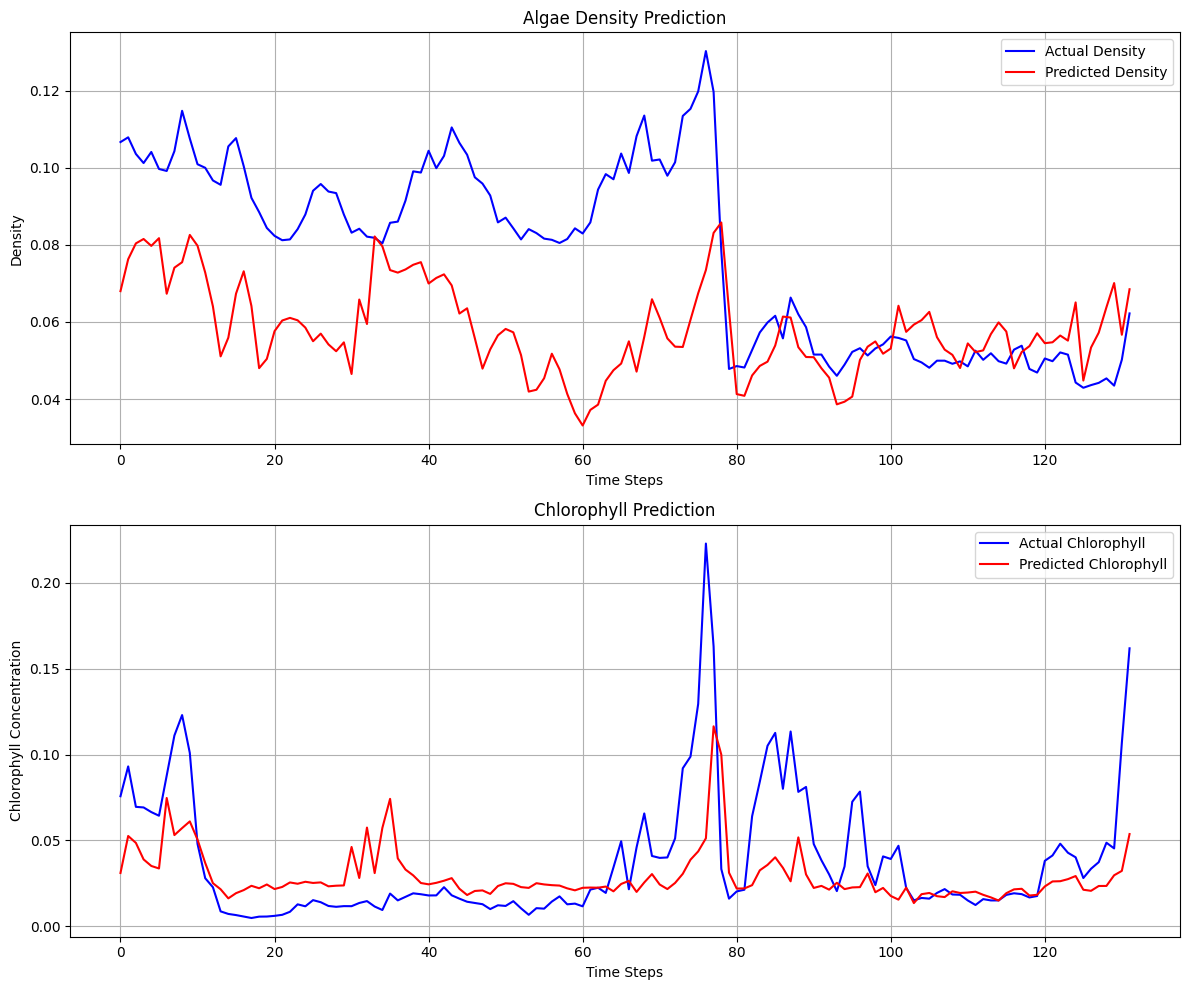

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 添加批归一化
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # 添加dropout
        self.dropout = nn.Dropout(dropout)
        
        # 使用双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           bidirectional=True, 
                           dropout=dropout if num_layers > 1 else 0)
                           
        # 添加多层全连接网络
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),  # *2是因为双向LSTM
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # 应用批归一化
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        
        # LSTM层
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # 只使用最后一个时间步的输出
        out = self.dropout(out[:, -1, :])
        
        # 通过全连接层
        out = self.fc_layers(out)
        return out
    
def preprocess_data(df, sequence_length, prediction_step=3):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 对weather列进行独热编码
    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取每个目标变量的TOP15特征
    target_features = {}
    for target in ['density_mean_y', 'density_lower_y', 'density_upper_y', 
                  'chla_mean', 'chla_lower', 'chla_upper']:
        sorted_features = sorted(feature_importance[target].items(), 
                               key=lambda x: x[1]['composite_score'], 
                               reverse=True)[:15]
        target_features[target] = [feature[0] for feature in sorted_features]

    # 使用所有目标变量的TOP15特征的并集
    all_features = set()
    for features in target_features.values():
        all_features.update(features)
    features = list(all_features)
    
    # 检查特征是否存在于数据集中
    available_features = [f for f in features if f in df.columns]
    logging.info(f"Number of features used: {len(available_features)}")
    logging.info(f"Available features: {available_features}")
    
    # 添加目标变量
    available_features.extend(['density_mean_y', 'chla_mean'])
    df_features = df[available_features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=available_features, index=df.index)

    # 分割2024年前后的数据
    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    # 创建训练序列
    train_sequences = []
    for i in range(len(train_data) - sequence_length - prediction_step + 1):
        train_sequences.append(train_data.iloc[i:i+sequence_length].values)
    train_sequences = np.array(train_sequences)

    # 创建测试序列
    test_sequences = []
    for i in range(len(test_data) - sequence_length - prediction_step + 1):
        test_sequences.append(test_data.iloc[i:i+sequence_length].values)
    test_sequences = np.array(test_sequences)

    # 分割输入和目标
    X_train = train_sequences[:, :-prediction_step, :]
    y_train = train_sequences[:, -prediction_step, [available_features.index('density_mean_y'), available_features.index('chla_mean')]]
    
    X_test = test_sequences[:, :-prediction_step, :]
    y_test = test_sequences[:, -prediction_step, [available_features.index('density_mean_y'), available_features.index('chla_mean')]]

    # 添加数据验证步骤
    logging.info(f"Training data shape: {X_train.shape}")
    logging.info(f"Training labels shape: {y_train.shape}")
    logging.info(f"Training data range: [{X_train.min():.4f}, {X_train.max():.4f}]")
    logging.info(f"Training labels range: [{y_train.min():.4f}, {y_train.max():.4f}]")
    
    # 检查是否有无效值
    if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
        logging.error("Found NaN values in training data!")
    if np.any(np.isinf(X_train)) or np.any(np.isinf(y_train)):
        logging.error("Found Inf values in training data!")

    return X_train, y_train, X_test, y_test, scaler, available_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    prev_loss = float('inf')
    plateau_count = 0
    
    for epoch in range(epochs):
        total_loss = 0
        batch_losses = []
        
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # 检查输出和目标的值范围
            if epoch == 0 and i == 0:
                logging.info(f"Sample outputs range: [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")
                logging.info(f"Sample targets range: [{targets.min().item():.4f}, {targets.max().item():.4f}]")
            
            loss = criterion(outputs, targets)
            
            # 检查损失值是否有效
            if torch.isnan(loss) or torch.isinf(loss):
                logging.error(f"Invalid loss value at epoch {epoch}, batch {i}")
                continue
                
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
            batch_losses.append(loss.item())
        
        avg_loss = total_loss / len(train_loader)
        
        # 检查损失是否停滞
        if abs(avg_loss - prev_loss) < 1e-7:
            plateau_count += 1
        else:
            plateau_count = 0
            
        if plateau_count >= 5:
            logging.warning(f"Loss plateaued for 5 epochs at {avg_loss:.6f}")
            
        # 输出更详细的训练信息
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}:')
            logging.info(f'  Average Loss: {avg_loss:.6f}')
            logging.info(f'  Loss std: {np.std(batch_losses):.6f}')
            logging.info(f'  Loss range: [{min(batch_losses):.6f}, {max(batch_losses):.6f}]')
            
        prev_loss = avg_loss

def train_lstm_model_for_target(model, train_loader, criterion, optimizer, epochs, target_index):
    model.train()
    prev_loss = float('inf')
    plateau_count = 0
    
    for epoch in range(epochs):
        total_loss = 0
        batch_losses = []
        
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # 检查输出和目标的值范围
            if epoch == 0 and i == 0:
                logging.info(f"Sample outputs range: [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")
                logging.info(f"Sample targets range: [{targets.min().item():.4f}, {targets.max().item():.4f}]")
            
            loss = criterion(outputs[:, target_index], targets[:, target_index])
            
            # 检查损失值是否有效
            if torch.isnan(loss) or torch.isinf(loss):
                logging.error(f"Invalid loss value at epoch {epoch}, batch {i}")
                continue
                
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
            batch_losses.append(loss.item())
        
        avg_loss = total_loss / len(train_loader)
        
        # 检查损失是否停滞
        if abs(avg_loss - prev_loss) < 1e-7:
            plateau_count += 1
        else:
            plateau_count = 0
            
        if plateau_count >= 5:
            logging.warning(f"Loss plateaued for 5 epochs at {avg_loss:.6f}")
            
        # 输出更详细的训练信息
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss for target {target_index}: {avg_loss:.4f}')
            
        prev_loss = avg_loss

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot algae density prediction
    ax1.plot(targets[start_idx:end_idx, 0], label='Actual Density', color='blue')
    ax1.plot(predictions[start_idx:end_idx, 0], label='Predicted Density', color='red')
    ax1.set_title('Algae Density Prediction')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True)

    # Plot chlorophyll prediction
    ax2.plot(targets[start_idx:end_idx, 1], label='Actual Chlorophyll', color='blue')
    ax2.plot(predictions[start_idx:end_idx, 1], label='Predicted Chlorophyll', color='red')
    ax2.set_title('Chlorophyll Prediction')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Chlorophyll Concentration')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 64
        hidden_size = 32
        num_layers = 1
        output_size = 2  # Predict algae density and chlorophyll
        criterion = nn.HuberLoss()  # 比MSE对异常值更稳健
        epochs = 200
        prediction_step = 7  # Predict next 7 days
        sequence_length = 14  # Use past 14 days data

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {prediction_step}")
        X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_step)
        input_size = len(features)

        train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

        # 为每个目标创建单独的模型
        model_density = LSTMModel(input_size, hidden_size, num_layers, output_size)
        model_chla = LSTMModel(input_size, hidden_size, num_layers, output_size)
        
        # 使用AdamW优化器
        optimizer_density = torch.optim.AdamW(model_density.parameters(), lr=0.001, weight_decay=0.01)
        optimizer_chla = torch.optim.AdamW(model_chla.parameters(), lr=0.001, weight_decay=0.01)

        # 添加学习率调度器
        scheduler_density = torch.optim.lr_scheduler.OneCycleLR(
            optimizer_density,
            max_lr=0.001,
            epochs=epochs,
            steps_per_epoch=len(train_loader)
        )
        scheduler_chla = torch.optim.lr_scheduler.OneCycleLR(
            optimizer_chla,
            max_lr=0.001,
            epochs=epochs,
            steps_per_epoch=len(train_loader)
        )

        # 分别训练密度和叶绿素预测模型
        train_lstm_model_for_target(model_density, train_loader, criterion, optimizer_density, epochs, target_index=0)
        train_lstm_model_for_target(model_chla, train_loader, criterion, optimizer_chla, epochs, target_index=1)

        # 评估两个模型
        predictions_density, targets = evaluate_lstm_model(model_density, test_loader)
        predictions_chla, _ = evaluate_lstm_model(model_chla, test_loader)

        # 合并预测结果
        predictions = np.column_stack((predictions_density[:, 0], predictions_chla[:, 1]))

        # Calculate RMSE and MAE
        rmse_density = np.sqrt(mean_squared_error(targets[:, 0], predictions[:, 0]))
        mae_density = mean_absolute_error(targets[:, 0], predictions[:, 0])
        rmse_chla = np.sqrt(mean_squared_error(targets[:, 1], predictions[:, 1]))
        mae_chla = mean_absolute_error(targets[:, 1], predictions[:, 1])

        logging.info("\nPrediction Accuracy Evaluation:")
        logging.info(f"Algae Density RMSE: {rmse_density:.4f}, MAE: {mae_density:.4f}")
        logging.info(f"Chlorophyll RMSE: {rmse_chla:.4f}, MAE: {mae_chla:.4f}")

        # Plot prediction results
        plot_forecast(targets, predictions, title='LSTM Prediction Results')

    except Exception as e:
        logging.error(f"Program error: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()

## 分别获取密度预测的TOP10特征和叶绿素预测的TOP15特征

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
def preprocess_data(df, sequence_length, prediction_step=3):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 对weather列进行独热编码
    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 分别获取密度和叶绿素的特征
    density_features = []
    chla_features = []
    
    # 获取密度预测的TOP10特征
    sorted_density_features = sorted(feature_importance['density_mean_y'].items(), 
                                   key=lambda x: x[1]['composite_score'], 
                                   reverse=True)[:10]
    density_features = [feature[0] for feature in sorted_density_features]
    
    # 获取叶绿素预测的TOP15特征
    sorted_chla_features = sorted(feature_importance['chla_mean'].items(), 
                                key=lambda x: x[1]['composite_score'], 
                                reverse=True)[:15]
    chla_features = [feature[0] for feature in sorted_chla_features]

    # 检查特征是否存在于数据集中
    available_density_features = [f for f in density_features if f in df.columns]
    available_chla_features = [f for f in chla_features if f in df.columns]
    
    logging.info(f"Number of density features: {len(available_density_features)}")
    logging.info(f"Density features: {available_density_features}")
    logging.info(f"Number of chlorophyll features: {len(available_chla_features)}")
    logging.info(f"Chlorophyll features: {available_chla_features}")
    
    # 为密度模型准备数据
    density_features_with_target = available_density_features + ['density_mean_y']
    df_density = df[density_features_with_target]
    scaler_density = MinMaxScaler()
    df_density_scaled = pd.DataFrame(scaler_density.fit_transform(df_density), 
                                   columns=density_features_with_target, 
                                   index=df.index)
    
    # 为叶绿素模型准备数据
    chla_features_with_target = available_chla_features + ['chla_mean']
    df_chla = df[chla_features_with_target]
    scaler_chla = MinMaxScaler()
    df_chla_scaled = pd.DataFrame(scaler_chla.fit_transform(df_chla), 
                                 columns=chla_features_with_target, 
                                 index=df.index)

    # 分割训练和测试数据
    train_density = df_density_scaled[df_density_scaled.index.year < 2024]
    test_density = df_density_scaled[df_density_scaled.index.year >= 2024]
    
    train_chla = df_chla_scaled[df_chla_scaled.index.year < 2024]
    test_chla = df_chla_scaled[df_chla_scaled.index.year >= 2024]

    # 创建序列数据
    def create_sequences(data):
        sequences = []
        for i in range(len(data) - sequence_length - prediction_step + 1):
            sequences.append(data.iloc[i:i+sequence_length].values)
        return np.array(sequences)

    # 创建密度数据的序列
    train_sequences_density = create_sequences(train_density)
    test_sequences_density = create_sequences(test_density)
    
    # 创建叶绿素数据的序列
    train_sequences_chla = create_sequences(train_chla)
    test_sequences_chla = create_sequences(test_chla)

    # 准备训练和测试数据
    X_train_density = train_sequences_density[:, :-prediction_step, :-1]
    y_train_density = train_sequences_density[:, -prediction_step, -1]
    
    X_test_density = test_sequences_density[:, :-prediction_step, :-1]
    y_test_density = test_sequences_density[:, -prediction_step, -1]
    
    X_train_chla = train_sequences_chla[:, :-prediction_step, :-1]
    y_train_chla = train_sequences_chla[:, -prediction_step, -1]
    
    X_test_chla = test_sequences_chla[:, :-prediction_step, :-1]
    y_test_chla = test_sequences_chla[:, -prediction_step, -1]

    return (X_train_density, y_train_density, X_test_density, y_test_density,
            X_train_chla, y_train_chla, X_test_chla, y_test_chla,
            scaler_density, scaler_chla,
            available_density_features, available_chla_features)

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

def train_lstm_model_for_target(model, train_loader, criterion, optimizer, epochs, target_index):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs[:, target_index], targets[:, target_index])  # 只计算当前目标的损失
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss for target {target_index}: {avg_loss:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot algae density prediction
    ax1.plot(targets[start_idx:end_idx, 0], label='Actual Density', color='blue')
    ax1.plot(predictions[start_idx:end_idx, 0], label='Predicted Density', color='red')
    ax1.set_title('Algae Density Prediction')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True)

    # Plot chlorophyll prediction
    ax2.plot(targets[start_idx:end_idx, 1], label='Actual Chlorophyll', color='blue')
    ax2.plot(predictions[start_idx:end_idx, 1], label='Predicted Chlorophyll', color='red')
    ax2.set_title('Chlorophyll Prediction')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Chlorophyll Concentration')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 2
        output_size = 2  # Predict algae density and chlorophyll
        criterion = nn.MSELoss()
        epochs = 200
        prediction_step = 7  # Predict next 7 days
        sequence_length = 14  # Use past 14 days data

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {prediction_step}")
        X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_step)
        input_size = len(features)

        train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

        # 为每个目标创建单独的模型
        model_density = LSTMModel(input_size, hidden_size, num_layers, output_size)
        model_chla = LSTMModel(input_size, hidden_size, num_layers, output_size)
        
        optimizer_density = torch.optim.Adam(model_density.parameters(), lr=0.001)
        optimizer_chla = torch.optim.Adam(model_chla.parameters(), lr=0.001)

        # 分别训练密度和叶绿素预测模型
        train_lstm_model_for_target(model_density, train_loader, criterion, optimizer_density, epochs, target_index=0)
        train_lstm_model_for_target(model_chla, train_loader, criterion, optimizer_chla, epochs, target_index=1)

        # 评估两个模型
        predictions_density, targets = evaluate_lstm_model(model_density, test_loader)
        predictions_chla, _ = evaluate_lstm_model(model_chla, test_loader)

        # 合并预测结果
        predictions = np.column_stack((predictions_density[:, 0], predictions_chla[:, 1]))

        # Calculate RMSE and MAE
        rmse_density = np.sqrt(mean_squared_error(targets[:, 0], predictions[:, 0]))
        mae_density = mean_absolute_error(targets[:, 0], predictions[:, 0])
        rmse_chla = np.sqrt(mean_squared_error(targets[:, 1], predictions[:, 1]))
        mae_chla = mean_absolute_error(targets[:, 1], predictions[:, 1])

        logging.info("\nPrediction Accuracy Evaluation:")
        logging.info(f"Algae Density RMSE: {rmse_density:.4f}, MAE: {mae_density:.4f}")
        logging.info(f"Chlorophyll RMSE: {rmse_chla:.4f}, MAE: {mae_chla:.4f}")

        # Plot prediction results
        plot_forecast(targets, predictions, title='LSTM Prediction Results')

    except Exception as e:
        logging.error(f"Program error: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()

2024-11-09 22:24:44,399 - INFO - Successfully loaded data file
2024-11-09 22:24:44,399 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-09 22:24:44,409 - INFO - Number of density features: 10
2024-11-09 22:24:44,410 - INFO - Density features: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-09 22:24:44,411 - INFO - Number of chlorophyll features: 15
2024-11-09 22:24:44,411 - INFO - Chlorophyll features: ['pH', 'permanganate', 'TP', 'max_temperature', 'temperature', 'min_temperature', 'TN', 'weather_阴', 'oxygen', 'weather_小雨', 'b4', 'weather_霾', 'b1', 'b3', 'b2']
2024-11-09 22:24:44,505 - ERROR - Program error: too many values to unpack (expected 6)
2024-11-09 22:24:44,517 - ERROR - Traceback (most recent call last):
  File "/tmp/ipykernel_7703/3630581116.py", line 216, in main
    X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_